# Test Calculator

In [1]:
from Calculator import LSRMCalculator
from ase.io import read
from ase.units import kcal, mol

In [2]:
atoms = read('/home/hul/v-yunyangli/lightnp_amlt/lightnp/example.xyz')
calc = LSRMCalculator('/home/hul/v-yunyangli/lightnp_amlt/amlt/flying-skink/HUL_NIPS-2-LSRM-AT_AT/checkpoints/AT_AT_radius3_broadcast/2023_05_12_16_48_56__Visnorm_shared_LSRMNorm2_2branchSerial/best_model/checkpoint-best.pth.tar', device='cuda:0')
atoms.calc = calc

In [3]:
atoms.get_potential_energy() /  (kcal / mol)

array([[-1154980.8]], dtype=float32)

In [4]:
atoms.get_forces() / (kcal / mol)

array([[ 1.10658169e+00,  1.04326849e+01, -1.27742398e+00],
       [ 4.24296856e+00, -8.58424091e+00,  6.60319376e+00],
       [ 5.37196212e-02, -2.72235179e+00,  1.85758507e+00],
       [-5.27705288e+00,  7.22340393e+00, -1.31662245e+01],
       [ 9.22986805e-01,  3.46815109e+00, -2.71347213e+00],
       [ 1.40133297e+00, -6.05789709e+00,  7.19825506e+00],
       [-9.56360912e+00,  5.88979101e+00, -3.01790276e+01],
       [-8.48947525e-01, -1.13715649e+01,  6.09427023e+00],
       [-9.98743713e-01, -8.04864502e+00,  8.40790663e-03],
       [-3.31331897e+00, -4.90163422e+01,  1.17415848e+01],
       [-2.93812847e+00,  1.79581344e+00, -6.13650179e+00],
       [ 1.31730280e+01,  3.32385755e+00,  3.67654572e+01],
       [-2.01546028e-01,  2.81552863e+00, -5.28226185e+00],
       [ 6.75076771e+00,  4.11020355e+01, -4.23861414e-01],
       [-2.55456972e+00,  9.46649837e+00, -1.15089245e+01],
       [-9.95206879e-04, -5.65129232e+00,  4.42755222e+00],
       [ 2.93140602e+00, -4.74056530e+00

# Analysis Traj

In [25]:
import numpy as np
from ase.units import fs

def calculate_velocities(xyz, dt):
    # Compute the difference in coordinates between each time point
    delta_xyz = np.diff(xyz, axis=0)
    # Divide by the time step to get the velocities
    v = delta_xyz / dt
    return v

In [27]:
atat = np.load('dataset/md22_AT-AT.npz')
coords = atat.f.R[:-1]

print(coords.shape)

v =  calculate_velocities(coords, 1 * fs)

np.save('./dataset_V.npy', v)

coords = coords[::100]
v = v[::100]

np.savez('sample/AT_AT_sample_fs.npz', R=coords, V=v)

coords.shape, v.shape

(20000, 60, 3)


((200, 60, 3), (200, 60, 3))

In [9]:
import os
import glob
from ase.io import Trajectory
import readline
from tqdm import tqdm
import numpy as np

traj_names = glob.glob('./dft_logs/logs_*/*-traj.traj')
traj_names.sort(key=lambda x: int(x.split('/')[2].split('_')[-1]))

all_V = []

for traj_name in tqdm(traj_names):
    traj = Trajectory(traj_name)
    all_V.extend([atoms.get_velocities() for atoms in traj][:-1])

all_V = np.array(all_V)

np.save('./dft_V_drop_last.npy', all_V)

all_V.shape

100%|██████████| 200/200 [00:05<00:00, 39.24it/s]


(20000, 60, 3)

In [10]:
import os
import glob
from ase.io import Trajectory
import readline
from tqdm import tqdm
import numpy as np

traj_names = glob.glob('./lsrm_logs/logs_*/*-traj.traj')
traj_names.sort(key=lambda x: int(x.split('/')[2].split('_')[-1]))

all_V = []

for traj_name in tqdm(traj_names):
    traj = Trajectory(traj_name)
    all_V.extend([atoms.get_velocities() for atoms in traj][:-1])

all_V = np.array(all_V)

np.save('./lsrm_V_drop_last.npy', all_V)

all_V.shape

100%|██████████| 200/200 [00:05<00:00, 36.24it/s]


(20000, 60, 3)

In [11]:
import numpy as np
from scipy.fftpack import fft, fftfreq
from ase.io import Trajectory
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d as gaussian


def pdos_f(V, dt):
    """
    Calculate the phonon density of states from a trajectory of
    velocities (power spectrum of the velocity auto-correlation
    function).

    Parameters
    ----------
    V : :obj:`numpy.ndarray`
        (dims N x T) velocities of N degrees of freedom for
        trajetory of length T
    dt : float
        time between steps in trajectory (fs)

    Returns
    -------
    freq : :obj:`numpy.ndarray`
        (dims T) Frequencies (cm^-1)
    pdos : :obj:`numpy.ndarray`
        (dims T) Density of states (a.u.)
    """
    
    n_steps = V.shape[1]

    # mean velocity auto-correlation for all degrees of freedom
    vac2 = [np.correlate(v, v, 'full') for v in V]
    vac2 /= np.linalg.norm(vac2, axis=1)[:, None]
    vac2 = np.mean(vac2, axis=0)

    # power spectrum (phonon density of states)
    pdos = np.abs(fft(vac2))**2
    pdos /= np.linalg.norm(pdos) / 2 # spectrum is symmetric

    freq = fftfreq(2*n_steps-1, dt) * 33356.4095198152 # Frequency in cm^-1

    return freq[:n_steps], pdos[:n_steps]

In [19]:
V_dft = np.load('dft_V_drop_last.npy')
V_dft = V_dft[::2]
print(V_dft.shape)
dt = 2

n_steps = V_dft.shape[0]
V_dft = V_dft.reshape(n_steps, -1).T
freq_dft, pdos_dft = pdos_f(V_dft, dt)

(10000, 60, 3)


In [20]:
V_lsrm = np.load('lsrm_V_drop_last.npy')
V_lsrm = V_lsrm[::2]
print(V_lsrm.shape)
dt = 2

n_steps = V_lsrm.shape[0]
V_lsrm = V_lsrm.reshape(n_steps, -1).T
freq_lsrm, pdos_lsrm = pdos_f(V_lsrm, dt)

(10000, 60, 3)


In [28]:
V_dataset = np.load('dataset_V.npy')
V_dataset = V_dataset[::2]
print(V_dataset.shape)
dt = 2

n_steps = V_dataset.shape[0]
V_dataset = V_dataset.reshape(n_steps, -1).T
freq_dataset, pdos_dataset = pdos_f(V_dataset, dt)

(10000, 60, 3)


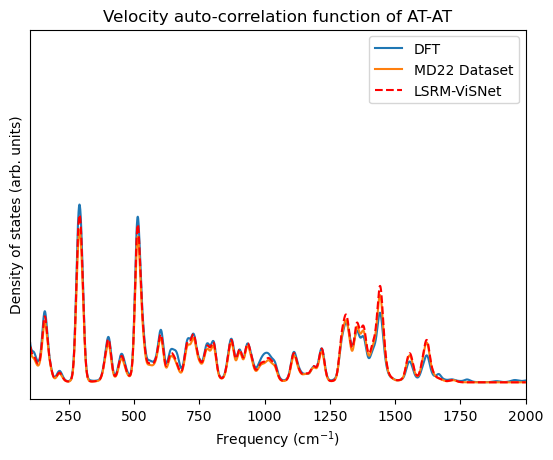

In [79]:
pdos_new_lsrm = gaussian(pdos_lsrm, sigma=10)
pdos_new_dft = gaussian(pdos_dft, sigma=10)
pdos_new_dataset = gaussian(pdos_dataset, sigma=10)

plt.plot(freq_dft, pdos_new_dft, label='DFT')
plt.plot(freq_dataset, pdos_new_dataset, label='MD22 Dataset')

plt.plot(freq_lsrm, pdos_new_lsrm, label='LSRM-ViSNet', color='red', linestyle='--')

plt.yticks([])
plt.xlim(100, 2000)

plt.xlabel('Frequency (cm$^{-1}$)')
plt.ylabel('Density of states (arb. units)')
plt.title('Velocity auto-correlation function of AT-AT')
plt.legend()
plt.savefig('vaf.png', dpi=300, bbox_inches='tight')
plt.show()

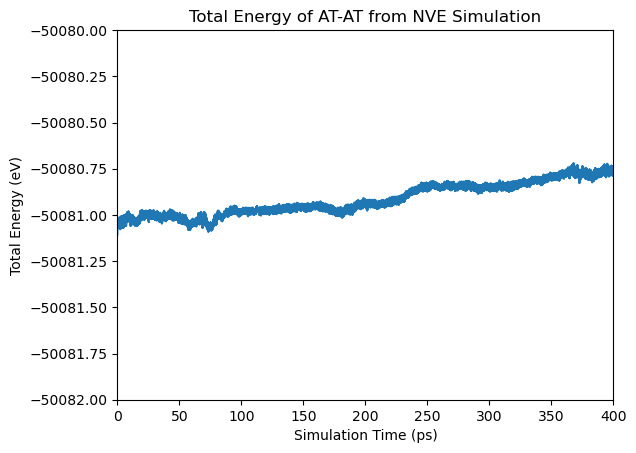

In [3]:
import re  
import numpy as np
import matplotlib.pyplot as plt  
  
log_file = open('./logs_md22_AT_AT_0/temp.logs', 'r').read()
  
# 通过正则表达式找到所有的Etot值  
Etot_values = re.findall("Etot = (.*?)eV", log_file)  
  
# 转换为浮点数  
Etot_values = np.array([float(value) for value in Etot_values])
  
# 创建步骤列表  
steps = np.array(range(len(Etot_values))) * 0.001
  
# 创建散点图 
plt.plot(steps[:], Etot_values[:])
  
# 添加标题和轴标签  
plt.xlabel('Simulation Time (ps)')  
plt.ylabel('Total Energy (eV)')
plt.title('Total Energy of AT-AT from NVE Simulation')

plt.xlim(0, 400)
plt.ylim(-50082, -50080)  
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

plt.savefig('NVE.png', dpi=300, bbox_inches='tight') 
plt.show()  


In [ ]:
import numpy as np

# Defining the sliding window size
window_size = 200000

# Initializing variables to record the minimum and maximum values within each window
min_max_values = []

# Sliding the window through the data
for i in range(len(etot_values) - window_size + 1):
    window = etot_values[i:i + window_size]
    min_max_values.append((min(window), max(window)))

# Converting the list of tuples into a NumPy array for easier processing
min_max_array = np.array(min_max_values)

# Finding the window with the minimum difference between max and min
diff_min_max = min_max_array[:, 1] - min_max_array[:, 0]
min_diff_index = np.argmin(diff_min_max)

# Extracting the specific window with the minimum max-min difference
selected_window = etot_values[min_diff_index:min_diff_index + window_size]

# Plotting the selected window
plt.figure(figsize=(12, 6))
plt.plot(range(min_diff_index, min_diff_index + window_size), selected_window, marker='o', linestyle='-', color='r')
plt.title(f'Etot vs Step for the Window with Min Difference (Window starting at Step {min_diff_index})')
plt.xlabel('Step')
plt.ylabel('Total Energy (Etot) [eV]')
plt.grid(True)
plt.show()